In [ ]:
# Attack imports
from simba import simba_attack_image
from hsja import hop_skip_jump_attack

# Helper imports
from data import CIFAR10, IMAGENETTE
import utils

# Numerical computing and display imports
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

# Other imports
from datetime import datetime
import logging
import os

In [ ]:
# Load and Prepare the Data
folder_path = '../../images/'
dataset = 'imagenette'    
if dataset == 'cifar10':
    images = CIFAR10()
if dataset == 'imagenette':
    images = IMAGENETTE()
x = images.load()
images.save_to_disk(x, folder_path, num_images=100)
folder_path = utils.move_data_to_temp_ram(folder_path, ram_size_mb=50)

In [41]:
# SIMBA Hyperparams
simba_epsilon = 0.9
simba_hamming_threshold = 20
simba_max_steps = 7000

# HSJA Hyperparams
hsja_max_steps = 10
hsja_grad_queries = 20
hsja_l2_threshold = 23
hsja_hamming_threshold = int(0.1 * 96 + 0.5)                # 10% ~ 10 and 50% = 48

In [ ]:
# Configure logging
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")
logging.basicConfig(filename='../../logs/untargeted/Eps-{simba_epsilon}_Bits-{simba_hamming_threshold}_{dt_string}.log',
                    format='%(asctime)s %(message)s',
                    level='DEBUG',
                    filemode='w',
                    force=True)
logger = logging.getLogger()
logger.info(f'Epsilon: {simba_epsilon}\tMismatched Bits Threshold: {simba_hamming_threshold}\n')

In [38]:
def joint_attack(img_path,
           epsilon, 
           logger,
           max_mismatched_bits,
           simba_max_steps,
           hsja_max_steps,
           grad_queries,
           l2_threshold,
           hamming_threshold):
    # Soft-label attack
    (simba_filename, simba_queries) = simba_attack_image(img_path=img_path, 
                                          eps=epsilon, 
                                          logger=logger,
                                          mismatched_threshold=max_mismatched_bits, 
                                          max_steps=simba_max_steps)
    # Hard-label attack
    (adv_img, hsja_queries) = hop_skip_jump_attack(orig_img_path=img_path, 
                                target_img_path=simba_filename, 
                                max_iters=hsja_max_steps, 
                                grad_queries=grad_queries, 
                                l2_threshold=l2_threshold, 
                                hamming_threshold=hamming_threshold)
    # Load the original image as well as the noisy adv. image outputted by simba
    orig_img, simba_img = utils.load_img(img_path), utils.load_img(simba_filename)
    return orig_img, simba_img, adv_img, simba_queries, hsja_queries

In [39]:
def plot_results(orig_img, simba_img, adv_img, hamming_threshold):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
    fig.suptitle(f'Hamming Threshold: {hamming_threshold}')
    ax1.imshow(orig_img)
    ax1.set_title('Orginal Image')
    ax2.imshow(simba_img)
    ax2.set_title('Noisy Simba Image')
    ax3.imshow(adv_img.astype(np.uint8))
    ax3.set_title('Denoised Final Image')

Iteration: 1 	Add Hash: 0x4b3556673472782f4d494e5371764c62 	Add Hamm Dist: 0 	Sub Hash: 0x4b3556673472782f4d494e5371764c62 	Sub Hamm Dist: 0
Iteration: 2 	Add Hash: 0x4b3556673472782f4d494e5371764c62 	Add Hamm Dist: 0 	Sub Hash: 0x4b3556673472782f4d494e5371764c62 	Sub Hamm Dist: 0
Iteration: 3 	Add Hash: 0x4b3556673472782f4d494e5371764c62 	Add Hamm Dist: 0 	Sub Hash: 0x4b3556673472782f4d494e5371764c62 	Sub Hamm Dist: 0
Iteration: 4 	Add Hash: 0x4b3556673472782f4d494e5371764c62 	Add Hamm Dist: 0 	Sub Hash: 0x4b3556673472782f4d494e5371764c62 	Sub Hamm Dist: 0
Iteration: 5 	Add Hash: 0x4b3556673472782f4d494e5371764c62 	Add Hamm Dist: 0 	Sub Hash: 0x4b3556673472782f4d494e5371764c62 	Sub Hamm Dist: 0
Iteration: 6 	Add Hash: 0x4b3556673472782f4d494e5371764c62 	Add Hamm Dist: 0 	Sub Hash: 0x4b3556673472782f4d494e5371764c62 	Sub Hamm Dist: 0
Iteration: 7 	Add Hash: 0x4b3556673472782f4d494e5371764c62 	Add Hamm Dist: 0 	Sub Hash: 0x4b3556673472782f4d494e5371764c62 	Sub Hamm Dist: 0
Iteration: 8 

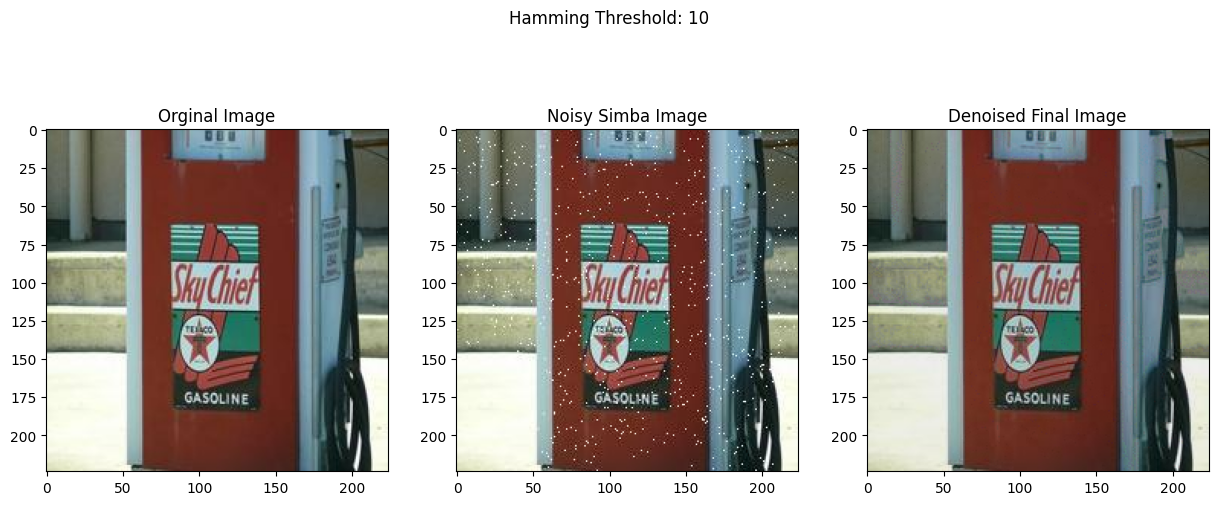

In [42]:
for i in range(1):
    # Format the path to the input image
    img_path = f'../../images/{9}.jpeg' 
    _, _, _, _, path, filetype = img_path.split('.')
    img_path = path.split('/')
    img_path = f'{folder_path}{img_path[2]}.{filetype}'

    # Attack NeuralHash 
    orig_img, simba_img, adv_img, simba_num_queries, hsja_num_queries = joint_attack(img_path, 
                                                                            simba_epsilon, 
                                                                            logger, 
                                                                            simba_hamming_threshold, 
                                                                            simba_max_steps, 
                                                                            hsja_max_steps, 
                                                                            hsja_grad_queries, 
                                                                            hsja_l2_threshold, 
                                                                            hsja_hamming_threshold)

    # Attack Metrics
    orig_img = utils.load_img(img_path)
    orig_hash, simba_hash, adv_hash = utils.compute_hash(orig_img), utils.compute_hash(simba_img), utils.compute_hash(adv_img)
    simba_hamming_dist = utils.distance(orig_hash, simba_hash, "hamming")
    final_hamming_dist = utils.distance(orig_hash, adv_hash, "hamming")
    simba_l2_dist = utils.distance(orig_img, simba_img, 'l2')
    final_l2_dist = utils.distance(orig_img, adv_img, 'l2')
    total_queries = simba_num_queries + hsja_num_queries
    if final_hamming_dist >= hsja_hamming_threshold and final_l2_dist < hsja_l2_threshold:
        success = 1
    else:
        success = 0

    attack_metrics = {
        'Image Path': [img_path],
        'Success': [success],
        'Queries': [total_queries],
        'Simba L2': [simba_l2_dist],
        'Final L2': [final_l2_dist],
        'Simba Hamming': [simba_hamming_dist],
        'Final Hamming': [final_hamming_dist]
    }

    # Save the results
    df = pd.DataFrame.from_dict(attack_metrics)
    file_path = f'metrics/{dt_string}_hamm_{hsja_hamming_threshold}_l2_{hsja_l2_threshold}.csv'
    if os.path.exists(file_path):
        df.to_csv(file_path, mode='a', index=False, header=False)
    else:
        df.to_csv(file_path, index=False, header=True)

    # Show the images/results
    plot_results(orig_img, simba_img, adv_img, hsja_hamming_threshold)